In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

from datetime import datetime
import itertools
import argparse
import re 
import os
import pickle 

from sklearn.preprocessing import StandardScaler


In [2]:
def get_data():
    #returns a T x 3 list of stock prices
    # each row is different stock
    # 0 = AAPL
    # 1 = MSI
    # 2 = SBUX
    df=pd.read_csv('aapl_msi_sbux.csv')
    return df.values

In [3]:
df=pd.read_csv('aapl_msi_sbux.csv')

In [4]:
df=df.head()

In [5]:
df.shape

(5, 3)

In [6]:
class ReplayBuffer:
  def __init__(self, obs_dim, act_dim, size):
    self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
    self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
    self.acts_buf = np.zeros(size, dtype=np.uint8)
    self.rews_buf = np.zeros(size, dtype=np.float32)
    self.done_buf = np.zeros(size, dtype=np.uint8)
    self.ptr, self.size, self.max_size = 0, 0, size

  def store(self, obs, act, rew, next_obs, done):
    self.obs1_buf[self.ptr] = obs
    self.obs2_buf[self.ptr] = next_obs
    self.acts_buf[self.ptr] = act
    self.rews_buf[self.ptr] = rew
    self.done_buf[self.ptr] = done
    self.ptr = (self.ptr+1) % self.max_size
    self.size = min(self.size+1, self.max_size)

  def sample_batch(self, batch_size=32):
    idxs = np.random.randint(0, self.size, size=batch_size)
    return dict(s=self.obs1_buf[idxs],
                s2=self.obs2_buf[idxs],
                a=self.acts_buf[idxs],
                r=self.rews_buf[idxs],
                d=self.done_buf[idxs])

In [7]:
def get_scaler(env):
  # return scikit-learn scaler object to scale the states
  # Note: you could also populate the replay buffer here

  states = []
  for _ in range(env.n_step):
    action = np.random.choice(env.action_space)
    state, reward, done, info = env.step(action)
    states.append(state)
    if done:
      break

  scaler = StandardScaler()
  scaler.fit(states)
  return scaler




def maybe_make_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)

In [8]:
def mlp(input_dim, n_action, n_hidden_layers=1, hidden_dim=32):
  """ A multi-layer perceptron """

  # input layer
  i = Input(shape=(input_dim,))
  x = i

  # hidden layers
  for _ in range(n_hidden_layers):
    x = Dense(hidden_dim, activation='relu')(x)
  
  # final layer
  x = Dense(n_action)(x)

  # make the model
  model = Model(i, x)

  model.compile(loss='mse', optimizer='adam')
  print((model.summary()))
  return model


In [9]:
class MultiStockEnv:
  """
  A 3-stock trading environment.
  State: vector of size 7 (n_stock * 2 + 1)
    - # shares of stock 1 owned
    - # shares of stock 2 owned
    - # shares of stock 3 owned
    - price of stock 1 (using daily close price)
    - price of stock 2
    - price of stock 3
    - cash owned (can be used to purchase more stocks)
  Action: categorical variable with 27 (3^3) possibilities
    - for each stock, you can:
    - 0 = sell
    - 1 = hold
    - 2 = buy
  """
  def __init__(self, data, initial_investment=20000):
    # data
    self.stock_price_history = data
    self.n_step, self.n_stock = self.stock_price_history.shape

    # instance attributes
    self.initial_investment = initial_investment
    self.cur_step = None
    self.stock_owned = None
    self.stock_price = None
    self.cash_in_hand = None

    self.action_space = np.arange(3**self.n_stock)

    # action permutations
    # returns a nested list with elements like:
    # [0,0,0]
    # [0,0,1]
    # [0,0,2]
    # [0,1,0]
    # [0,1,1]
    # etc.
    # 0 = sell
    # 1 = hold
    # 2 = buy
    self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

    # calculate size of state
    self.state_dim = self.n_stock * 2 + 1

    self.reset()


  def reset(self):
    self.cur_step = 0
    self.stock_owned = np.zeros(self.n_stock)
    self.stock_price = self.stock_price_history[self.cur_step]
    self.cash_in_hand = self.initial_investment
    return self._get_obs()


  def step(self, action):
    assert action in self.action_space

    # get current value before performing the action
    prev_val = self._get_val()

    # update price, i.e. go to the next day
    self.cur_step += 1
    self.stock_price = self.stock_price_history[self.cur_step]

    # perform the trade
    self._trade(action)

    # get the new value after taking the action
    cur_val = self._get_val()

    # reward is the increase in porfolio value
    reward = cur_val - prev_val

    # done if we have run out of data
    done = self.cur_step == self.n_step - 1

    # store the current value of the portfolio here
    info = {'cur_val': cur_val}

    # conform to the Gym API
    return self._get_obs(), reward, done, info


  def _get_obs(self):
    obs = np.empty(self.state_dim)
    obs[:self.n_stock] = self.stock_owned
    obs[self.n_stock:2*self.n_stock] = self.stock_price
    obs[-1] = self.cash_in_hand
    return obs
    


  def _get_val(self):
    return self.stock_owned.dot(self.stock_price) + self.cash_in_hand


  def _trade(self, action):
    # index the action we want to perform
    # 0 = sell
    # 1 = hold
    # 2 = buy
    # e.g. [2,1,0] means:
    # buy first stock
    # hold second stock
    # sell third stock
    action_vec = self.action_list[action]
     # determine which stocks to buy or sell
    sell_index = [] # stores index of stocks we want to sell
    buy_index = [] # stores index of stocks we want to buy
    for i, a in enumerate(action_vec):
      if a == 0:
        sell_index.append(i)
      elif a == 2:
        buy_index.append(i)

    # sell any stocks we want to sell
    # then buy any stocks we want to buy
    if sell_index:
      # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
      for i in sell_index:
        self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
        self.stock_owned[i] = 0
    if buy_index:
      # NOTE: when buying, we will loop through each stock we want to buy,
      #       and buy one share at a time until we run out of cash
      can_buy = True
      while can_buy:
        for i in buy_index:
          if self.cash_in_hand > self.stock_price[i]:
            self.stock_owned[i] += 1 # buy one share
            self.cash_in_hand -= self.stock_price[i]
          else:
            can_buy = False


In [10]:
class DQNAgent(object):
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = ReplayBuffer(state_size, action_size, size=500)
    self.gamma = 0.95  # discount rate
    self.epsilon = 1.0  # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.model = mlp(state_size, action_size)


  def update_replay_memory(self, state, action, reward, next_state, done):
    self.memory.store(state, action, reward, next_state, done)


  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])  # returns action


  def replay(self, batch_size=32):
    # first check if replay buffer contains enough data
    if self.memory.size < batch_size:
      return

    # sample a batch of data from the replay memory
    minibatch = self.memory.sample_batch(batch_size)
    states = minibatch['s']
    actions = minibatch['a']
    rewards = minibatch['r']
    next_states = minibatch['s2']
    done = minibatch['d']

    # Calculate the tentative target: Q(s',a)
    target = rewards + (1 - done) * self.gamma * np.amax(self.model.predict(next_states), axis=1)

    # With the Keras API, the target (usually) must have the same
    # shape as the predictions.
    # However, we only need to update the network for the actions
    # which were actually taken.
    # We can accomplish this by setting the target to be equal to
    # the prediction for all values.
    # Then, only change the targets for the actions taken.
    # Q(s,a)
    target_full = self.model.predict(states)
    target_full[np.arange(batch_size), actions] = target

    # Run one training step
    self.model.train_on_batch(states, target_full)

    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay


  def load(self, name):
    self.model.load_weights(name)


  def save(self, name):
    self.model.save_weights(name)

In [11]:
def play_one_episode(agent, env, scaler, batch_size, mode):
    state = env.reset()
    state = scaler.transform([state])
    done = False
    episode_steps = 0  # Limit the number of steps in an episode

    while not done and episode_steps < max_steps_per_episode:  # Add limit on steps
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        
        if mode == 'train':
            agent.update_replay_memory(state, action, reward, next_state, done)
            agent.replay(batch_size)

        state = next_state
        episode_steps += 1  # Increment step count
    return info['cur_val']


In [12]:
!pip install --upgrade "pip<24.1"


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\PHED\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [13]:
!pip install tensorflow



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\PHED\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [14]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [25]:
if __name__ == '__main__':
    models_folder = 'rl_trader_models'
    rewards_folder = 'rl_trader_rewards'
    num_episodes = 20  # Start with fewer episodes for debugging
    batch_size = 32
    initial_investment = 20000

    max_steps_per_episode = 100

    class Args:
        mode = 'train'  # Default mode set to 'train'
    args = Args()

    maybe_make_dir(models_folder)
    maybe_make_dir(rewards_folder)

    data = get_data()
    n_timesteps, n_stocks = data.shape
    n_train = n_timesteps // 2
    train_data = data[:n_train]
    test_data = data[n_train:]

    env = MultiStockEnv(train_data, initial_investment)
    state_size = env.state_dim
    action_size = len(env.action_space)
    agent = DQNAgent(state_size, action_size)
    scaler = get_scaler(env)

    portfolio_value = []
    rewards = []  # Define rewards here

    if args.mode == 'test':
        with open(f'{models_folder}/scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        env = MultiStockEnv(test_data, initial_investment)
        agent.epsilon = 0.01
        agent.load(f'{models_folder}/dqn.weights.h5')

    for e in range(num_episodes):
        t0 = datetime.now()
        val = play_one_episode(agent, env, scaler, batch_size, args.mode)
        dt = datetime.now() - t0
        print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
        portfolio_value.append(val)
        rewards.append(val)  # Collect reward values in each episode

    if args.mode == 'train':
        agent.save(f'{models_folder}/dqn.weights.h5')  # Ensure filename ends with `.weights.h5`
        with open(f'{models_folder}/scaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
        np.save(f'{rewards_folder}/train.npy', np.array(rewards))  # Save rewards to train.npy



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 27)             │           891 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,147 (4.48 KB)

 Trainable params: 1,147 (4.48 KB)

 Non-trainable params: 0 (0.00 B)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━

average reward: 20284.32, min: 16721.00, max: 22935.88


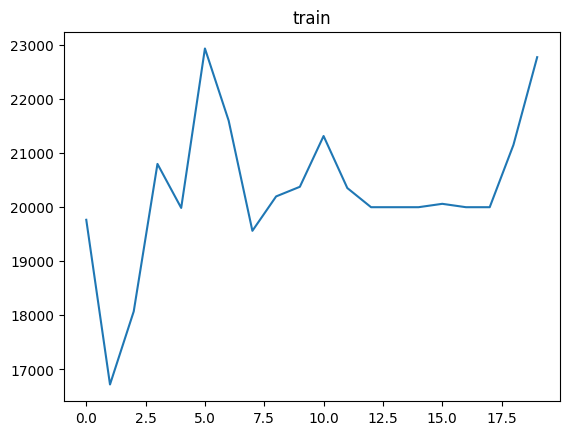

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Directly set the mode here instead of using argparse
mode = 'train'  # Change to 'test' if you want to test

# Load rewards data based on mode
a = np.load(f'rl_trader_rewards/{mode}.npy')

print(f"average reward: {a.mean():.2f}, min: {a.min():.2f}, max: {a.max():.2f}")

if mode == 'train':
    # Show the training progress
    plt.plot(a)
else:
    # Test - show a histogram of rewards
    plt.hist(a, bins=20)

plt.title(mode)
plt.show()
